In [2]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import gensim

import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/Documents/Data/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from utils.text import *
from django.db.models import Q, Count, Func, F, Sum, Value, Case, When, IntegerField

### importing data

In [2]:
run_qs = RunStats.objects.filter(psearch__id=89, method="BD", status=3)

pd.DataFrame.from_dict(run_qs.values('run_id', 'coherence', 'exclusivity', 'K', 'alpha',
                                'top_chain_var', 'rng_seed', 'max_iter'))

,K,alpha,coherence,exclusivity,max_iter,rng_seed,run_id,top_chain_var
0,35,0.01,0.419955,0.804016,200,1,2350,0.010
1,40,0.01,0.458939,0.868018,200,1,2351,0.010
2,45,0.01,NaN,NaN,200,1,2352,0.010
3,45,0.05,0.473385,0.912385,50,1,2156,0.010
4,45,0.01,0.464178,0.878157,50,1,2155,0.010
5,45,0.01,0.511302,0.690445,50,1,2158,0.005
6,45,0.10,0.482888,0.901765,50,1,2157,0.010
7,45,0.05,0.415776,0.848308,50,1,2167,0.050
8,45,0.05,0.491613,0.746280,50,1,2160,0.005
9,45,0.01,0.400095,0.863986,50,1,2166,0.050


In [3]:
run_id = 2155
# for ISIE talk: run_id = 1749

save_dir = "./plots/topic_analysis_{}".format(run_id)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

dts = DocTopic.objects.filter(run_id=run_id)
# total score of all DocTopics
print(dts.aggregate(
    n = Sum('score')
))
# total score of DocTopics, sorted by topic
pd.DataFrame.from_dict(list(dts.values('topic__id', 'topic__title').annotate(
    totalscore = Sum('score')
).order_by('-totalscore')))

{'n': 3934749.1500025}


,topic__id,topic__title,totalscore
0,178515,stop words,619234.291928
1,178481,procedural 1,273809.686006
2,178498,economic policy 1,202963.147750
3,178513,procedural 2,142553.991272
4,178495,europe,141410.998528
5,178489,procedural 3,120756.670825
6,178497,general policy statements,116614.982983
7,178478,German-French coal plan,115945.235466
8,178484,budget,110642.907628
9,178472,green opposition,101886.271129


### Overall DocTopic score - Time plot

In [4]:
topic_period_scores = dts.values('topic__title','ut__document__parlperiod__n').annotate(score = Sum('score'))

df = pd.DataFrame.from_dict(topic_period_scores)
df.columns = ['score', 'topic', 'parlperiod']
df_scores = df.pivot(index='parlperiod', columns='topic', values='score')
df_scores

topic,Berlin,German-French coal plan,agriculture,budget,budget 2,budget 3,coal mining industry,diplomacy & trade,east germany,economic policy 1,...,procedural 2,procedural 3,procedural 4,research & development,stop words,structural adjustment policy,subsidies,taxes,transport policy,unions & firms
parlperiod,,,,,,,,,,,,,,,,,,,,,
1,38662.514317,82180.699410,3226.030057,14777.766667,449.016288,793.938198,1240.560173,2684.419407,625.503506,5259.184545,...,27019.108167,4052.444579,5445.319866,87.261535,42455.501219,483.670881,373.221417,216.109967,1705.525034,13500.010385
2,8316.912258,17169.771031,10713.368650,18862.193420,327.755928,1223.235144,1893.688399,909.885907,158.924212,10684.007392,...,17904.680669,5905.980445,5342.082330,547.579738,43081.829464,238.656644,181.553121,191.335013,6873.259048,10168.651286
3,4250.540327,3258.547188,5559.137672,23009.948260,709.848779,1495.419598,6292.436745,1479.101861,106.526944,8019.934955,...,8282.888196,5795.060768,4777.972993,195.912859,28406.032437,119.449502,240.205526,212.160994,2562.576225,2595.689749
4,1560.232728,2345.020718,6982.997075,16216.458648,423.301524,1593.766447,13293.537586,915.872907,37.038656,9186.302627,...,6521.746912,4201.789367,3900.570182,227.049424,24287.465218,161.295498,93.126887,78.010439,1547.652251,2617.139825
5,1823.080039,2570.841959,9591.028694,16329.219999,663.151899,3449.011919,21370.031326,2851.867421,116.560991,27116.786938,...,13234.505203,12148.571429,13002.464683,2028.150996,46455.180457,2841.573572,332.119527,322.940772,3243.125883,2189.446708
6,330.314408,382.077638,1056.815335,3189.105459,245.240418,701.891086,1094.356242,655.165323,84.034250,4851.684845,...,2846.040524,8512.905260,2652.894010,480.451259,6739.686520,878.225360,32.217255,232.698102,298.421379,1054.152455
7,246.405048,440.005327,560.611964,3811.341367,528.141802,1609.113920,2036.556935,7655.084376,115.667869,15114.323769,...,7400.954648,17120.038814,9888.577806,3877.532267,25784.524513,914.385718,104.491389,713.516505,748.389101,2447.543117
8,555.904122,554.419117,769.262405,2575.235631,543.461562,3400.651199,1839.230515,12020.831346,256.478173,18791.329426,...,10641.459269,7713.425019,11715.576190,4047.751896,36845.027353,2929.686240,462.989277,1756.944603,634.169933,890.821373
9,485.541333,932.894531,662.971726,1322.152075,514.587255,2107.224479,686.989834,6274.420043,337.999859,11286.923394,...,3550.996179,1679.332454,5222.221090,2665.374152,24795.142729,2405.693031,425.446912,1014.107947,429.912922,2110.718048


In [5]:
# normalization
df_shares = df_scores.copy()
for i in df_shares.index:
    df_shares.loc[i] = df_scores.loc[i] / df_scores.loc[i].sum() * 100
df_shares

topic,Berlin,German-French coal plan,agriculture,budget,budget 2,budget 3,coal mining industry,diplomacy & trade,east germany,economic policy 1,...,procedural 2,procedural 3,procedural 4,research & development,stop words,structural adjustment policy,subsidies,taxes,transport policy,unions & firms
parlperiod,,,,,,,,,,,,,,,,,,,,,
1,11.013259,23.409687,0.918955,4.209539,0.127905,0.226158,0.353381,0.764674,0.178179,1.498112,...,7.696562,1.154364,1.551133,0.024857,12.093715,0.137777,0.106314,0.061560,0.485829,3.845562
2,3.183096,6.571313,4.100282,7.219047,0.125441,0.468164,0.724763,0.348237,0.060824,4.089045,...,6.852582,2.260371,2.044552,0.209573,16.488525,0.091340,0.069485,0.073229,2.630573,3.891805
3,2.278761,1.746942,2.980314,12.335882,0.380558,0.801711,3.373443,0.792963,0.057110,4.299574,...,4.440546,3.106795,2.561523,0.105031,15.228781,0.064038,0.128777,0.113742,1.373825,1.391577
4,1.088262,1.635652,4.870640,11.310978,0.295253,1.111652,9.272241,0.638821,0.025834,6.407445,...,4.548918,2.930748,2.720647,0.158367,16.940504,0.112504,0.064956,0.054412,1.079487,1.825455
5,0.660432,0.931317,3.474460,5.915447,0.240234,1.249444,7.741539,1.033122,0.042226,9.823367,...,4.794351,4.400959,4.710292,0.734721,16.828923,1.029393,0.120314,0.116989,1.174860,0.793152
6,0.527005,0.609592,1.686112,5.088106,0.391273,1.119843,1.746007,1.045293,0.134074,7.740694,...,4.540758,13.582043,4.232600,0.766543,10.752934,1.401178,0.051402,0.371262,0.476121,1.681863
7,0.135663,0.242253,0.308655,2.098401,0.290778,0.885926,1.121262,4.214641,0.063683,8.321456,...,4.074726,9.425738,5.444330,2.134844,14.196123,0.503431,0.057530,0.392839,0.412039,1.347538
8,0.216945,0.216365,0.300209,1.005001,0.212089,1.327125,0.717771,4.691203,0.100092,7.333431,...,4.152894,3.010211,4.572075,1.579660,14.378996,1.143328,0.180684,0.685658,0.247489,0.347648
9,0.305962,0.587859,0.417769,0.833148,0.324265,1.327858,0.432904,3.953798,0.212989,7.112404,...,2.237644,1.058224,3.290759,1.679574,15.624548,1.515937,0.268093,0.639036,0.270908,1.330060


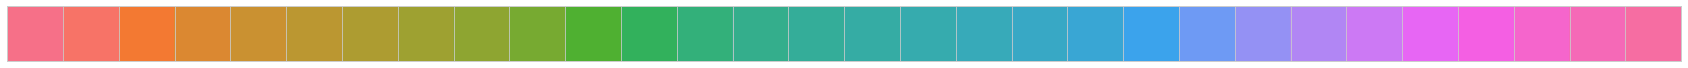

In [6]:
%matplotlib inline
# figure aesthetics
sns.set_style('whitegrid')
plt.rcParams['lines.linewidth'] = 3

sns.set_palette('husl', 30)
#sns.set_palette('muted')
sns.palplot(sns.color_palette())

In [7]:
def time_evolution_plot(dfs, filename, title=None, scale=1):
    
    sns.set_context("talk")
    sns.set_style("ticks")
    sns.set_style({'axes.spines.bottom': True,
                   'axes.grid':True,
                   'axes.spines.left': False,
                   'axes.spines.right': False,
                   'axes.spines.top': False,
                   'ytick.left': False})


    fig = plt.figure(figsize=(10, 0.7 * len(dfs.columns)))
    ax = fig.gca()
    #ax.autoscale(enable=False)
    #ax.set_ylim([0 - max_val, len(dfs.index) + max_val])
    #ax.set(ylim=(0 - max_val, len(dfs.index) + max_val))
    plt.yticks([])
    plt.xticks(range(1,20))

    max_val = scale * dfs.max().max() + 5
    #print(max_val)

    for i, t in enumerate(reversed(dfs.columns)):
        plt.fill_between(dfs.index, dfs[t] + i*max_val, i*max_val - dfs[t], label=t)
        plt.text(19.3, (i+0.) *max_val, t)

    plt.xlabel('Parliamentary period')
    if title:
        plt.title(title)
    plt.savefig(filename, dpi=150, bbox_inches="tight")
    
def get_sorted_columns(df):
    
    # sort according to position of peak
    sel2 = df.copy()
    sel2.loc['peak_pos'] = [sel2[topic].idxmax() for topic in sel2.columns]
    sel2 = sel2.sort_values(by='peak_pos', axis=1)
    sel2 = sel2.drop('peak_pos')
    return sel2.columns

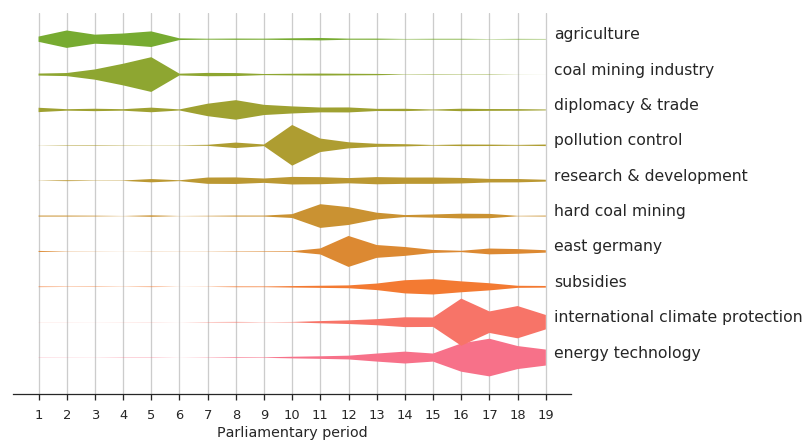

In [8]:
#dfs = df[["EU", "finance"]]
#dfs = df_shares[["hard coal mining",  "EU", "energy transition 3", "energy transition 2", "energy transition",
#          "economy & jobs", "east germany", "development", "climate protection", "climate policy"]]
#print(dfs)

selection = ["agriculture", "coal mining industry", "diplomacy & trade",
                 "east germany", "energy technology",
                 "hard coal mining", "international climate protection",
                 "pollution control", "research & development", "subsidies"]

sorted_selection = get_sorted_columns(df_scores[selection])
sorted_all = get_sorted_columns(df_scores)

# plot scores
time_evolution_plot(df_scores[sorted_selection], os.path.join(save_dir, 'topic_evolution_scores_run{}_selection.png'.format(run_id)), scale=1.5)
#time_evolution_plot(df_scores[sorted_all], os.path.join(save_dir, 'topic_evolution_scores_run{}_all.png'.format(run_id)))

# plot shares
#time_evolution_plot(df_shares[sorted_selection], os.path.join(save_dir, 'topic_evolution_shares_run{}_selection.png'.format(run_id)))
#time_evolution_plot(df_shares[sorted_all], os.path.join(save_dir, 'topic_evolution_shares_run{}_all.png'.format(run_id)))

In [9]:
sorted_selection

Index(['agriculture', 'coal mining industry', 'diplomacy & trade',
       'pollution control', 'research & development', 'hard coal mining',
       'east germany', 'subsidies', 'international climate protection',
       'energy technology'],
      dtype='object', name='topic')

--------------------------------------------------

In [9]:
topic_dir = "plots/topic_analysis_2155/"
topic_classification = pd.read_csv(topic_dir + '0_topic_list_2155_classification.csv', index_col=0)
#selected_topics = topic_classification[topic_classification['classification'] != 'procedural and general politics']['label'].values

In [10]:
# normalization with selection
sel_shares = df_scores[selected_topics].copy()

for i in sel_shares.index:
    sum_score = sel_shares.loc[i].sum()
    sel_shares.loc[i] = sel_shares.loc[i] / sum_score * 100

# sel_shares.dtypes

sel_shares = sel_shares[get_sorted_columns(sel_shares)]

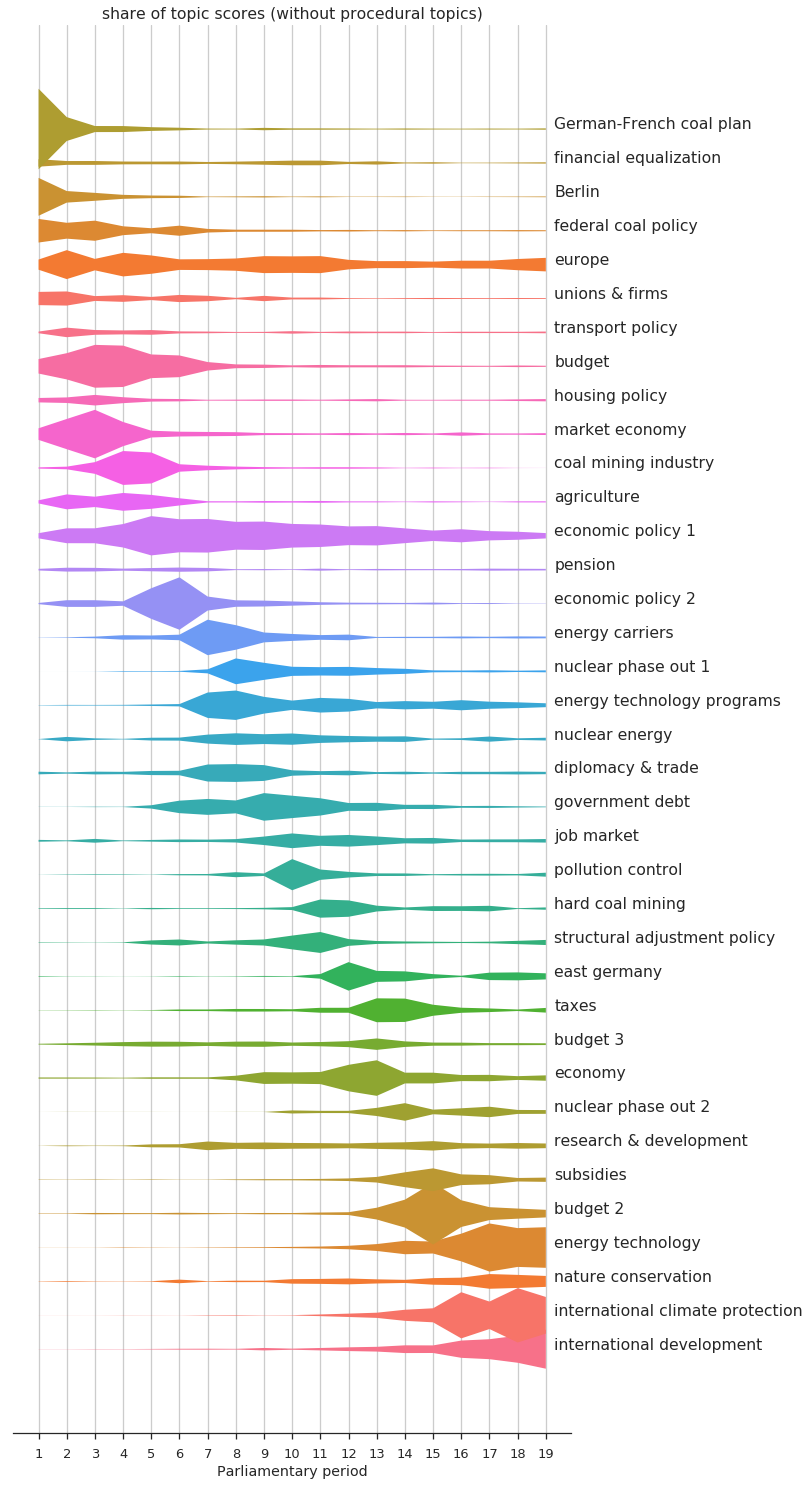

In [44]:
#sel_shares = df_scores[selected_topics].copy()

time_evolution_plot(sel_shares, os.path.join(save_dir, 'topic_evolution_shares_run{}_wo_procedural.png'.format(run_id)),
                   title='share of topic scores (without procedural topics)', scale=0.7)

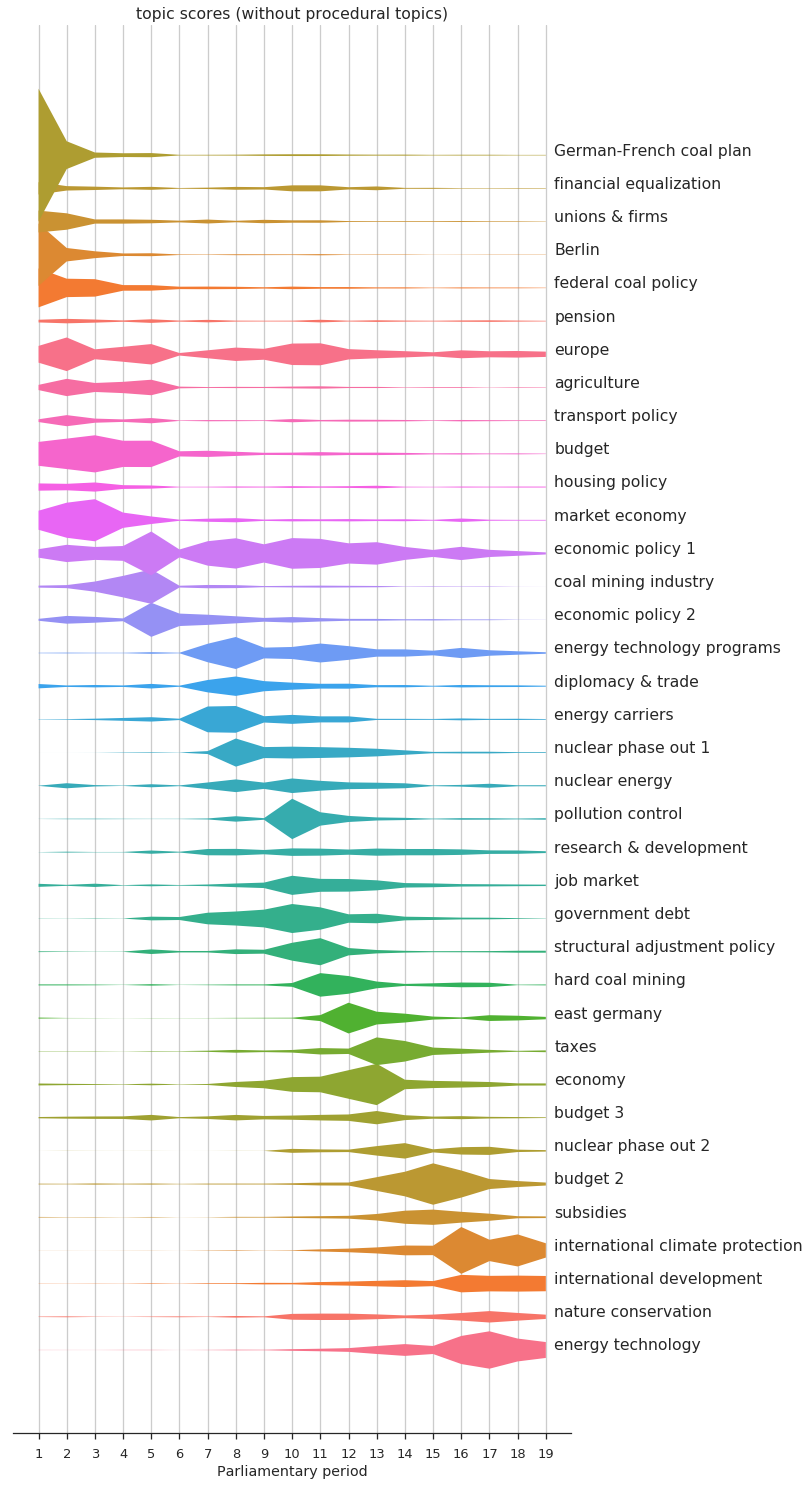

In [13]:
time_evolution_plot(df_scores[get_sorted_columns(df_scores[selected_topics])], os.path.join(save_dir, 'topic_evolution_scores_run{}_wo_procedural.png'.format(run_id)),
                   title='topic scores (without procedural topics)', scale=0.5)

In [11]:
topic_classes = set(topic_classification['classification'])
print(topic_classes)

{'economy and finance', 'international', 'energy and environment', 'regional aspects', 'procedural and general politics'}


In [12]:
topic_classes = ['economy and finance', 'energy and environment', 'regional aspects', 'international']

index = pd.Index([])

for topic_class in topic_classes:
    topics_in_class = topic_classification[topic_classification['classification'] == topic_class]['label'].values
        
    index = index.append(get_sorted_columns(sel_shares[topics_in_class]))

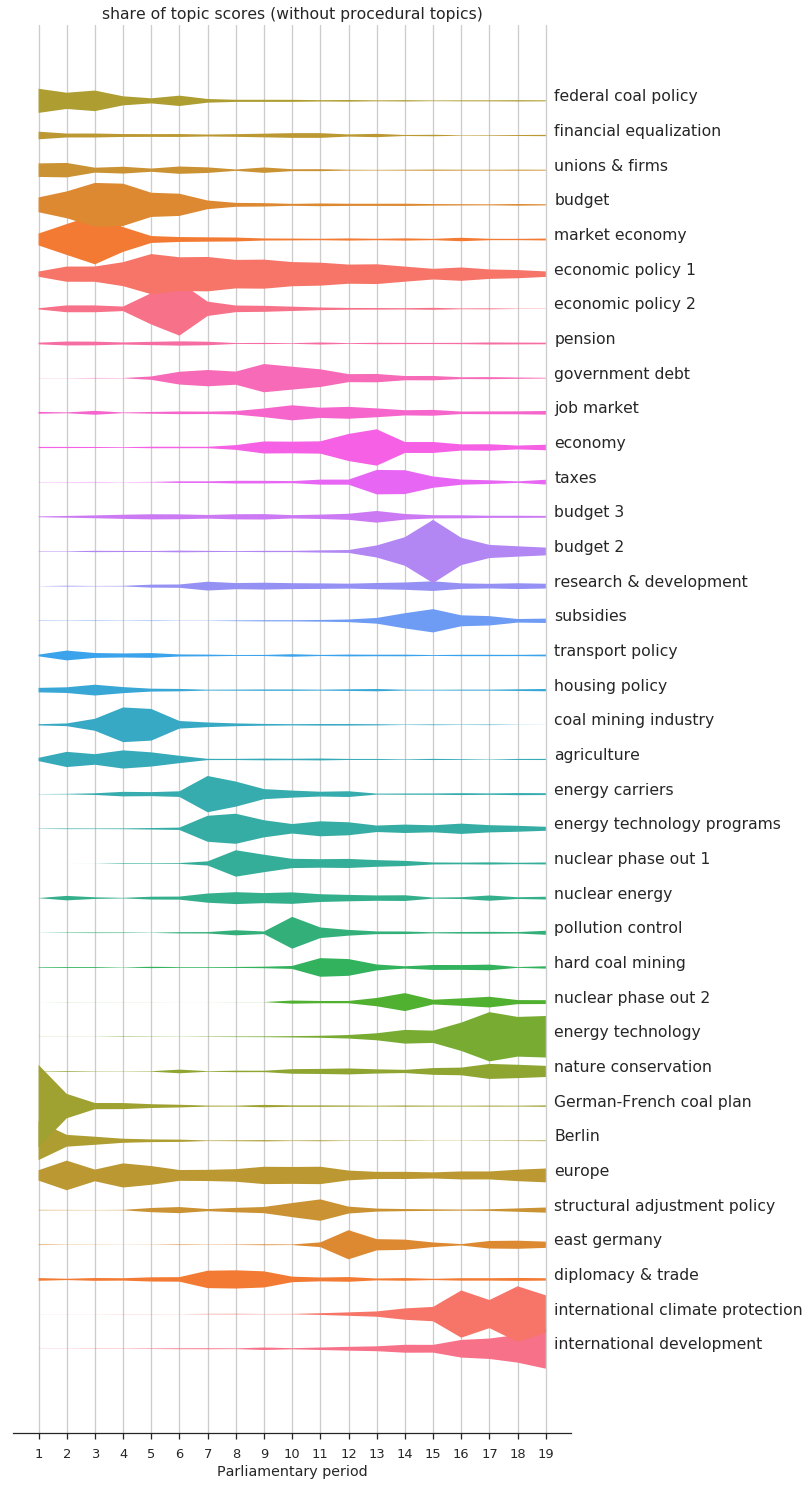

In [13]:
time_evolution_plot(sel_shares[index], os.path.join(save_dir, 'topic_evolution_shares_run{}_wo_procedural.png'.format(run_id)),
                   title='share of topic scores (without procedural topics)', scale=0.7)

# the same as a barplot and transposed

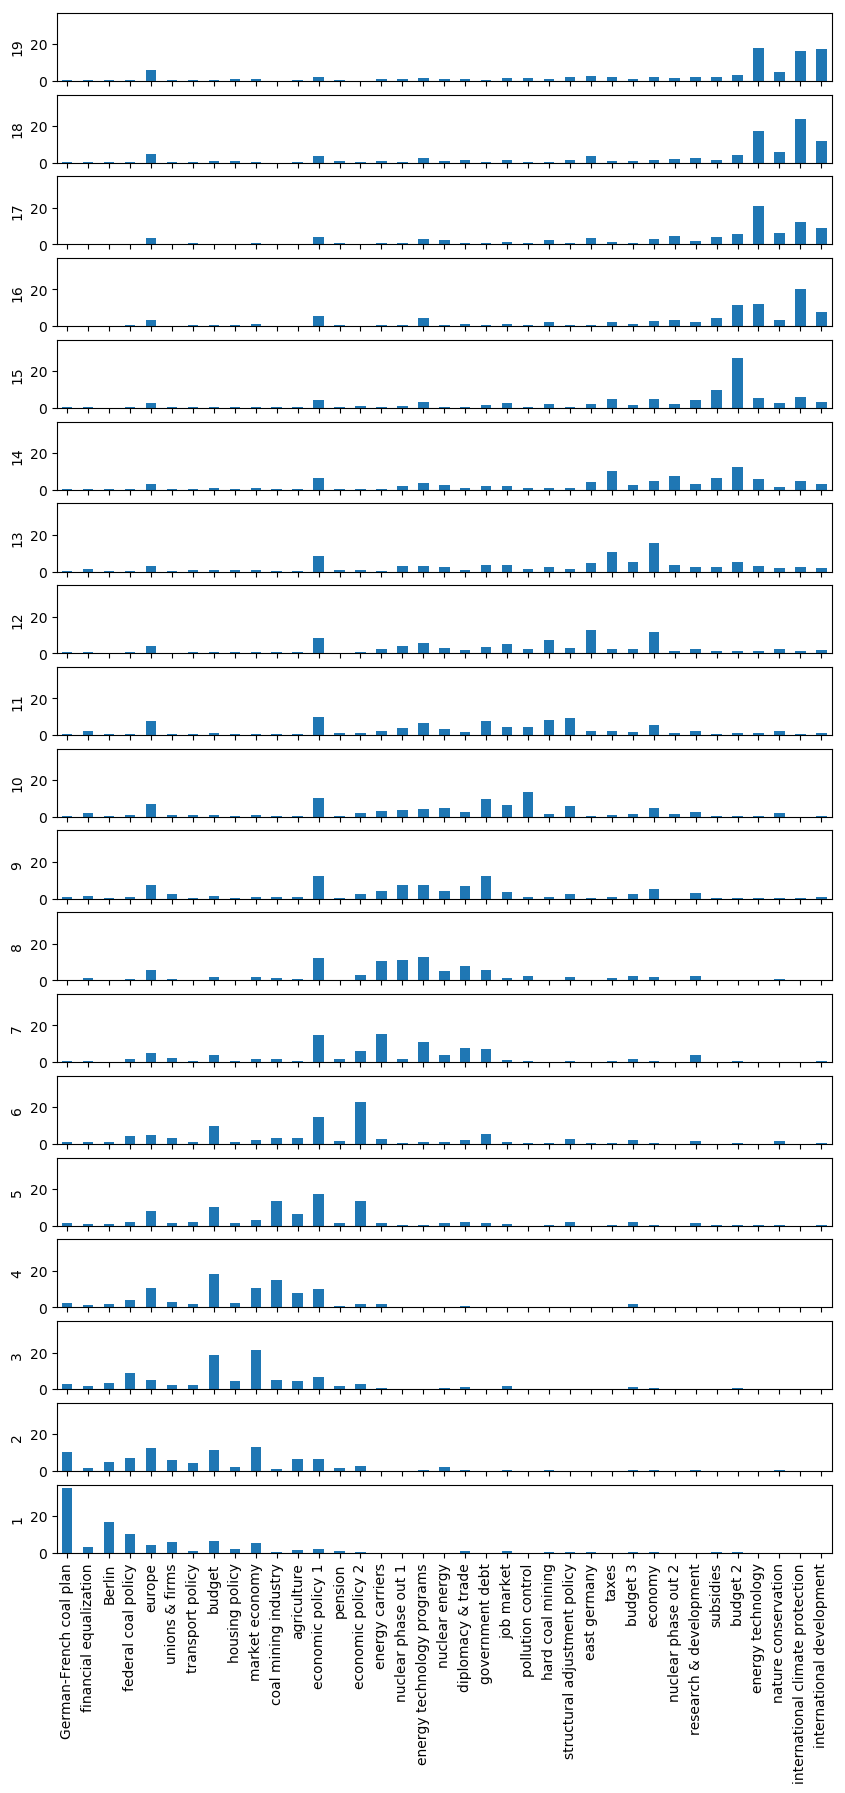

In [16]:
sns.reset_orig()
fig, ax = plt.subplots(19, 1, sharex=True, sharey=True, figsize=(10, 20))
pp_to_pos = {i: 19 - i for i in range(19, 0, -1)}

for i in range(1, 20):
    sel_shares.loc[i].plot.bar(ax=ax[pp_to_pos[i]])
    ax[pp_to_pos[i]].set_ylabel(i)

ax[18].set_xlabel("")
plt.savefig(os.path.join(save_dir, 'topic_evolution_shares_run{}_wo_procedural_barplot_simple.png'.format(run_id)))

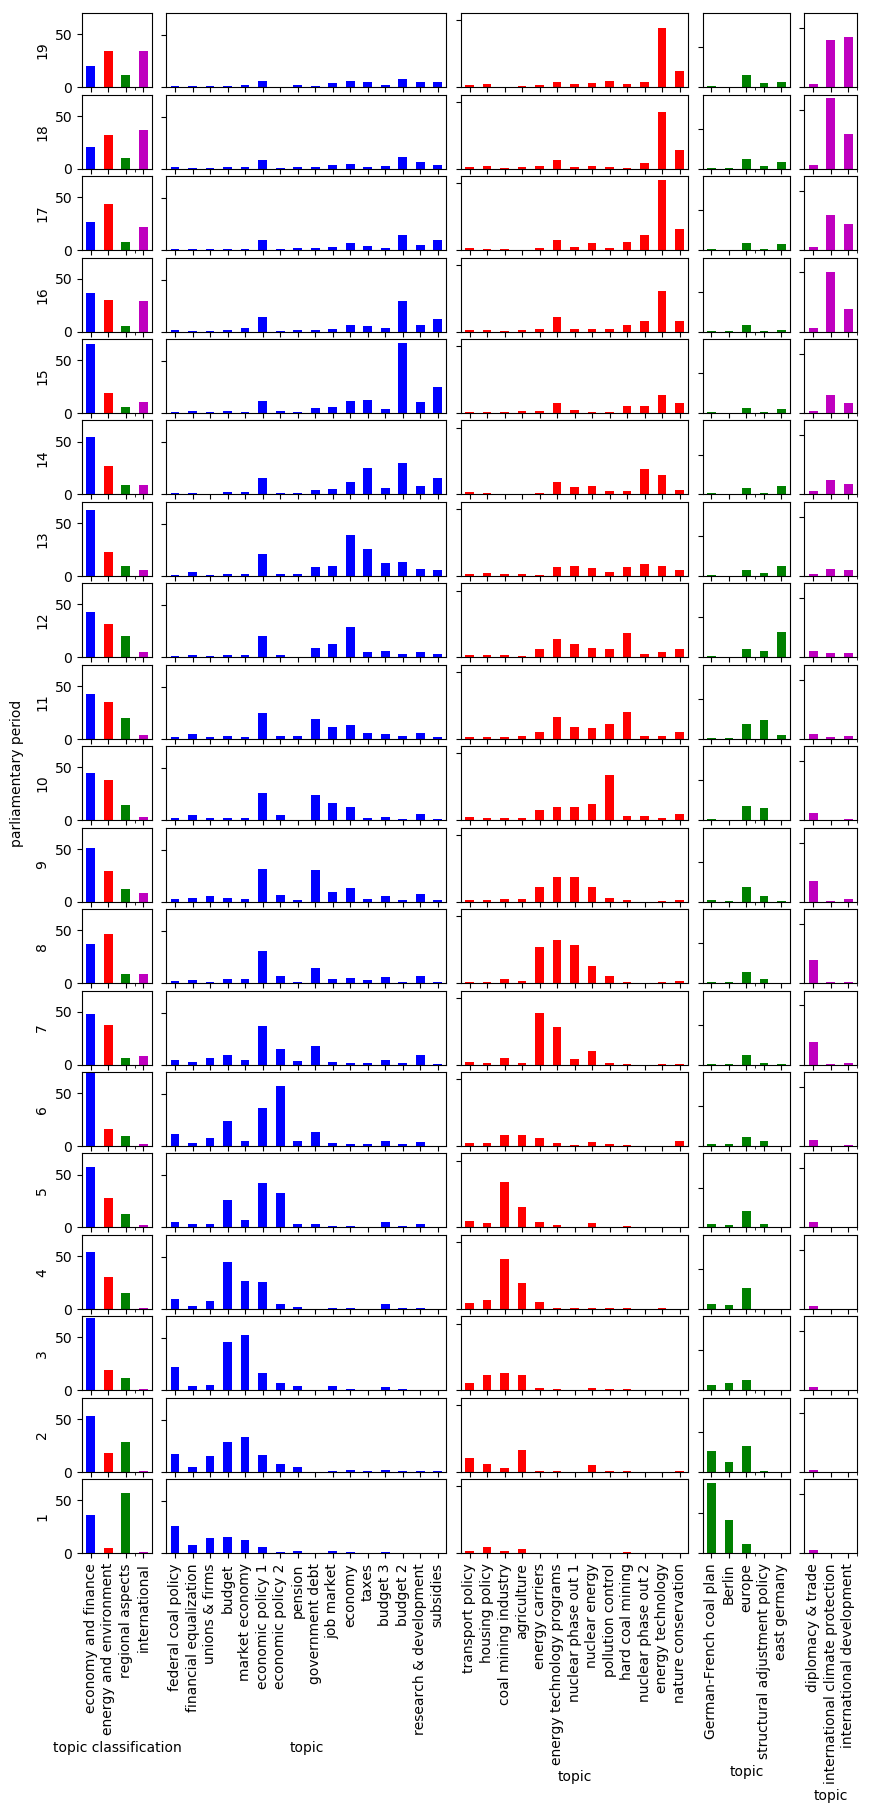

In [15]:
sns.reset_orig()

topics_per_class = []
for topic_class in topic_classes:
    topics_in_class = topic_classification[topic_classification['classification'] == topic_class]['label'].values
    topics_per_class.append(len(topics_in_class))

topics_per_class.insert(0, len(topic_classes))

fig, ax = plt.subplots(19, len(topic_classes) + 1, sharex='col', sharey='col',
                       figsize=(10, 20), gridspec_kw={'width_ratios': topics_per_class})

pp_to_pos = {i: 19 - i for i in range(19, 0, -1)}
colors = ["b", "r", "g", "m"]

class_shares = pd.DataFrame(index=sel_shares.index, columns=topic_classes)

for j, topic_class in enumerate(topic_classes):
    topics_in_class = topic_classification[topic_classification['classification'] == topic_class]['label'].values

    sel = sel_shares[topics_in_class]
    sel = sel[get_sorted_columns(sel)]
    for i in range(1, 20):
        sel.loc[i].plot.bar(ax=ax[pp_to_pos[i]][j+1], color=colors[j])
        ax[pp_to_pos[i]][j+1].set_ylabel(i)
        #ax[pp_to_pos[i]][0].set_ylim([0, 20])

        class_shares.loc[i, topic_class] = sel.loc[i].sum()
        
    ax[18][j+1].set_xlabel(topic_class)

    
for i in range(1, 20):
    class_shares.loc[i].plot.bar(ax=ax[pp_to_pos[i]][0], color=colors)
    ax[pp_to_pos[i]][0].set_ylabel(i)
    ax[pp_to_pos[i]][0].set_ylim([0, 70])

ax[18][0].set_xlabel("topic classification")
    
plt.subplots_adjust(wspace=0.1, hspace=0.1)
fig.text(0.06, 0.5, 'parliamentary period', ha='center', va='center', rotation='vertical')
plt.savefig(os.path.join(save_dir, 'topic_evolution_shares_run{}_wo_procedural_barplot.png'.format(run_id)),
           dpi=150, bbox_inches="tight")

----------------------------------------------------------------